In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:

gps_gf = np.load("gps_data.npy")
gps_df = pd.DataFrame(gps_gf[1:,:], columns=gps_gf[0,:])
cols_to_convert = gps_df.columns[gps_df.columns != 'interval_id']
gps_df[cols_to_convert] = gps_df[cols_to_convert].apply(pd.to_numeric, errors='coerce') 

In [3]:
def rotation_ned(lat, lon):
    R_ned = np.array([[-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
                     [-np.sin(lon), np.cos(lon),0],
                     [-np.cos(lat)*np.cos(lon), -np.cos(lat)*np.sin(lon), -np.sin(lat)]])
    return R_ned 
    
def ecef_to_ned(gps_pos_ref):
    deltas = (gps_pos_ref[['Node[1].ECEF.X', 'Node[1].ECEF.Y', 'Node[1].ECEF.Z']].values /1000) - (gps_pos_ref[['Node[1].ECEF.X.ref', 'Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref']].values/1000)   
    
    #use reference lat and lon points 
    lons = gps_pos_ref['Node[1].LLH.Lon.ref'] * (np.pi/180) 
    lats = gps_pos_ref['Node[1].LLH.Lat.ref'] * (np.pi/180)

    ned_values = []
    mags = []
    for i, (lat, lon) in enumerate(zip(lats, lons)): 
        rotation_matrix = rotation_ned(lat,lon)
        norm = np.linalg.norm(deltas[i,:])
        ned_vec = rotation_matrix @ deltas[i,:] / norm
        ned_mag = np.linalg.norm(ned_vec)
        mags.append(ned_mag )
        ned_values.append(ned_vec * norm)
    ned_values = np.array(ned_values)
    return ned_values, np.array(mags)

def gps_dead_reckoning(gps_ned, dt, start, end):
    
    plt.plot(gps_ned[:,0], label="x")
    plt.plot(gps_ned[:,1], label="y")
    plt.plot(gps_ned[:,2], label="z")
    plt.title("Ned vectors")
    plt.show()

    vel_ned = gps_ned / dt.values[:, np.newaxis]
    acc_ned = np.diff(vel_ned, axis=0) / dt.values[1:, np.newaxis]  

    displacement = [np.cumsum(gps_ned[:, 0], axis=0), 
                    np.cumsum(gps_ned[:, 1], axis=0),
                    np.cumsum(gps_ned[:, 2], axis=0)]
    
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].plot(np.cumsum(gps_ned[start:end, 0], axis=0), label='X')  
    axes[0].plot(np.cumsum(gps_ned[start:end, 1], axis=0), label='Y') 
    axes[0].plot(np.cumsum(gps_ned[start:end, 2], axis=0), label='Z')  
    axes[0].legend()
    axes[0].set_title("Total Displacement")

    vel_norm = np.linalg.norm(vel_ned[:,:2], axis=1)
    axes[1].plot(vel_ned[start:end, 0], label='X') 
    axes[1].plot(vel_ned[start:end, 1], label='Y')
    axes[1].plot(vel_ned[start:end, 2], label='Z')
    axes[1].legend()    
    axes[1].set_title("Velocity")

    axes[2].plot(acc_ned[start:end, 0], label='X')  
    axes[2].plot(acc_ned[start:end, 1], label='Y')  
    axes[2].plot(acc_ned[start:end, 2], label='Z', alpha=.2) 
    axes[2].legend()
    axes[2].set_title("Acceleration")
    fig.suptitle("GPS Dead Reckoning in NED Frame")
    plt.tight_layout()
    plt.show()

    return displacement, vel_ned, acc_ned

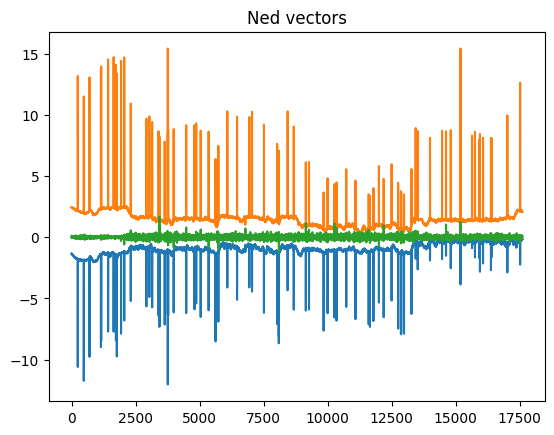

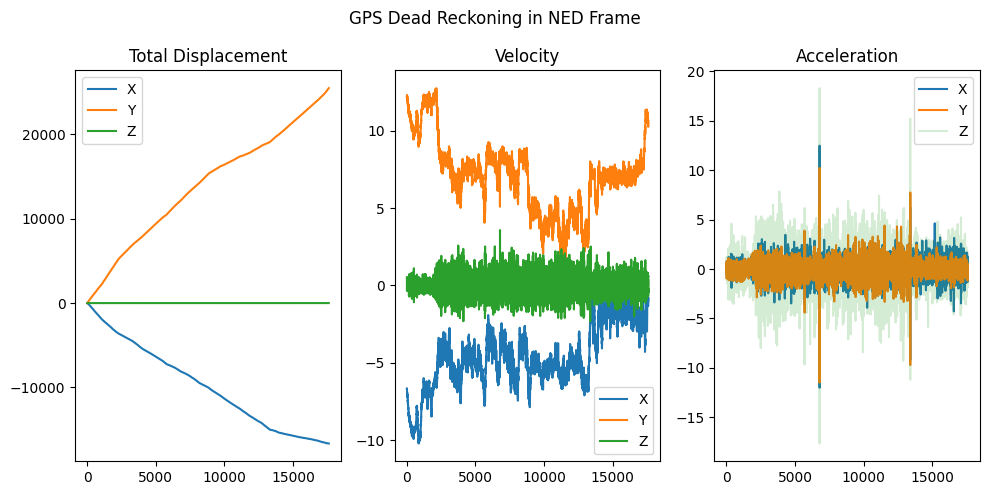

In [4]:
new_gps = gps_df.copy()
modified_shift = gps_df[['Node[1].ECEF.modified', 'timestamp']][1:]

new_gps[['Node[1].ECEF.X.ref','Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref','Node[1].LLH.Lat.ref','Node[1].LLH.Lon.ref','timestamp_ref']] = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y","Node[1].ECEF.Z",'Node[1].LLH.Lat','Node[1].LLH.Lon', 'timestamp']].shift(1)

gps_pos_ref = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y","Node[1].ECEF.Z",'Node[1].ECEF.X.ref','Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref',
                      'Node[1].LLH.Lat.ref', 'Node[1].LLH.Lon.ref','timestamp','timestamp_ref','interval_id']].dropna()

gps_ned, ned_mags = ecef_to_ned(gps_pos_ref)

dt = gps_pos_ref['timestamp'] - gps_pos_ref['timestamp_ref']
displacement , vel_ned, acc_ned = gps_dead_reckoning(gps_ned, dt, start=0, end=-1)

[[-1.32999405  2.44132359  0.10805924]
 [-1.32869674  2.43567182  0.10688156]
 [-1.3278482   2.43462569  0.06857419]
 ...
 [-0.16242187  2.11289556  0.12726246]
 [-0.18516717  2.12371483  0.12436636]
 [-0.18171772  2.11850672  0.10229335]]
(17609, 3)
(52827,)
[-1.32999405  2.44132359  0.10805924 ... -0.18171772  2.11850672
  0.10229335]


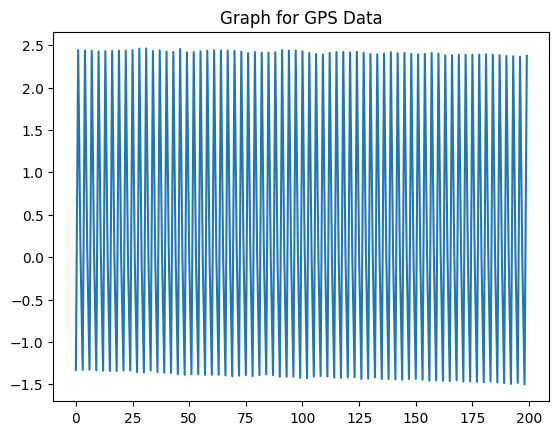

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualizing a small subset (size 200) of the gps (from the NED frame)

print((gps_ned))
print(gps_ned.shape)
new_gps = gps_ned.reshape(-1)
print(new_gps.shape)
print(new_gps)
plt.plot(np.arange(200), new_gps[:200])
plt.title("Graph for GPS Data")
plt.figure()
plt.show()